In [ ]:
#%pip install sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.6/766.6 MB 28.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 24.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 36.7 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 28.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 32.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 32.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 32.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.1/150.1 MB 30.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━

In [16]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
stocks=['aapl','googl','nvda','dal','xom','cvx','vz']
keywords={'aapl':'apple|aapl|tech|iphone','googl':'google|alphabet|tech|googl','nvda':'nvidia|nvda|gpu','dal':'delta|airline|travel|flight','xom':'exxon|energy|oil|gas','cvx':'chevron|energy|oil|gas','vz':'verizon|network|internet|broadband|telecom'}

In [9]:
# Use BERT embeddings to convert headlines into vector space
aapl_datetime = pd.read_csv('aapl_datetime.csv')
aapl_datetime['date']=pd.to_datetime(aapl_datetime['date'])
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(aapl_datetime['headline'])

# Perform KMeans clustering on embeddings
num_clusters = 2  # You can adjust this based on your data
clustering_model = KMeans(n_clusters=num_clusters, random_state=42)
clustering_model.fit(embeddings)

# Assign each headline to a cluster
aapl_datetime['cluster'] = clustering_model.labels_

# Remove duplicates within each cluster (based on dates)
aapl_datetime_BERT = aapl_datetime.drop_duplicates(subset=['cluster', 'date'], keep='first').reset_index(drop=True)
print(aapl_datetime_BERT)

                                               headline stock       date  \
0     AI Daily: Analyst sees Apple, Alibaba partners...  aapl 2025-03-03   
1     Is a $100B TSMC U.S. Manufacturing Investment ...  aapl 2025-03-03   
2     Nvidia (NVDA) Stock Rebounds from Post-Earning...  aapl 2025-02-28   
3     Dell reports mixed Q4 results, Intel delays Oh...  aapl 2025-02-28   
4     Five-Star Rated Analyst Pounds the Table on Ap...  aapl 2025-02-27   
...                                                 ...   ...        ...   
5024          Apple recalls some Verizon iPad 2 tablets  aapl 2011-06-11   
5025    Wall Street extends losses as banks, Apple drag  aapl 2011-06-06   
5026    Apple readies latest version of the halo effect  aapl 2011-06-05   
5027  Apple probes blast at Chinese plant linked to ...  aapl 2011-05-21   
5028  Google, Apple not unassailable in smartphone race  aapl 2011-05-19   

     exact_time  cluster  
0      18:30:36        1  
1      17:44:25        0  
2     

In [4]:
aapl_datetime_BERT.to_csv('aapl_datetime_BERT.csv', index=False)

In [ ]:
l={}
for x in stocks:
    x_datetime = pd.read_csv(x+'_datetime.csv')
    x_datetime['date']=pd.to_datetime(x_datetime['date'])
    model = SentenceTransformer('all-MiniLM-L6-v2')
    embeddings = model.encode(x_datetime['headline'])
    a=model.similarity(embeddings,embeddings)
    to_remove = set()
    # Compare within ±5-day windows
    for i in range(len(x_datetime)):
        if i in to_remove:
            continue
        current_date = x_datetime.loc[i, 'date']

        # Get indices of nearby dates (±5 days)
        nearby_indices = x_datetime[(x_datetime['date'] >= current_date - pd.Timedelta(days=5)) & 
                            (x_datetime['date'] <= current_date + pd.Timedelta(days=5))].index

        for j in nearby_indices:
            if i != j and j not in to_remove:
                similarity_score = a[i,j]
                if similarity_score > 0.6:
                    to_remove.add(j)
    # Remove duplicates
    x_datetime_cleaned = x_datetime.drop(list(to_remove)).reset_index(drop=True)
    x_datetime_cleaned=x_datetime_cleaned[['headline','stock','date','exact_time']]
    x_datetime_cleaned=x_datetime_cleaned[x_datetime_cleaned['headline'].str.contains(keywords[x],case=False,regex=True)]
    x_datetime_cleaned['headline']=x_datetime_cleaned['headline'].str.replace(';',' ').str.replace(',',' ')
    x_datetime_cleaned.to_csv(x+'_datetime_BERT3.csv',index=False)
    l[x]=len(x_datetime_cleaned)

In [18]:
lx=[]
ly=[]
for i in range(len(aapl_datetime)-1):
    lx.append(i)
    ly.append(a[i,i+1])

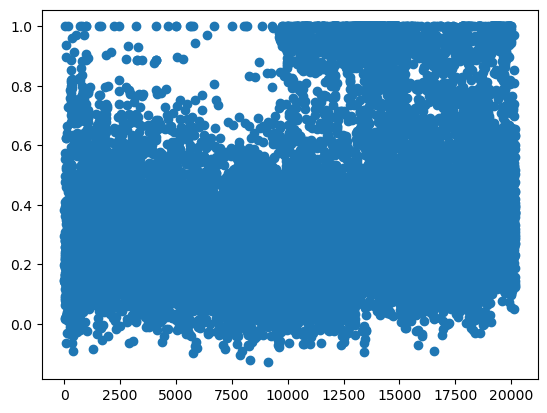

In [20]:
plt.scatter(lx,ly)
plt.show()